## 3-1、低阶API示范
下面的范例使用Tensorflow的低阶API实现线性回归模型和DNN分类模型。   

低阶API主要包括张量操作，计算图和自动微分。

In [2]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

### 一、线性回归模型
#### 1、准备数据

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

#样本数量
n =400

#生成测试数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10)
w0= tf.constant([[2.0],[-3.0]])
b0= tf.constant([3.0])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动

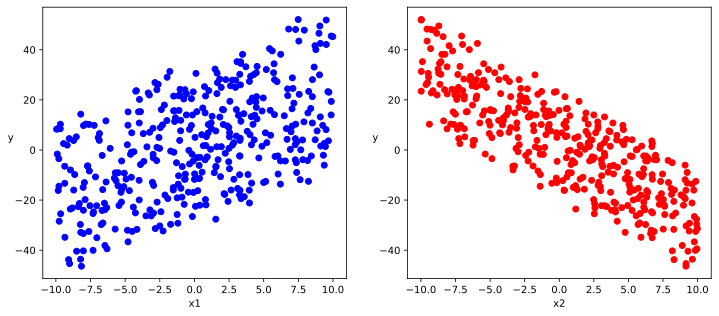

In [4]:
#数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0],c="b")
plt.xlabel("x1")
plt.ylabel("y",rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0],c ='r')
plt.xlabel("x2")
plt.ylabel("y",rotation=0)
plt.show()

In [5]:
#构建迭代器
def data_iter(features,labels,batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        indexs = indices[i:min(i+batch_size,num_examples)]
        yield tf.gather(X,indexs),tf.gather(Y,indexs)
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 9.092609   -5.9201217 ]
 [ 0.7267647  -6.011076  ]
 [-8.306362    2.5559158 ]
 [ 6.2262516  -8.261698  ]
 [ 3.5980206   8.989788  ]
 [ 0.34093666  3.9251633 ]
 [-5.5179405   1.186449  ]
 [ 3.9726114   9.600533  ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[ 42.546078 ]
 [ 25.271786 ]
 [-21.369114 ]
 [ 38.19701  ]
 [-18.657879 ]
 [ -6.1462436]
 [-14.227093 ]
 [-21.146763 ]], shape=(8, 1), dtype=float32)


#### 2、定义模型训练模型之低阶API定义示范

In [15]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

#定义模型
class LinearRegression:
    #正向传播
    def __call__(self,x):
        return x@w + b
    
    def loss_func(self,y_true,y_pred):
        return tf.reduce_mean((y_true-y_pred)**2/2)

model = LinearRegression()

#### 3、训练模型

In [17]:
#使用动态图调试

def train_step(model,features,labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels,predictions)
    #反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

In [18]:
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=428.0713>

In [19]:
def train_model(model,epochs):
    for epoch in range(epochs):
        for features,labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)
        if epoch%10 == 0:
            printbar()
            tf.print("epoch = ",epoch,"loss = ",loss)
            tf.print("w = ",w)
            tf.print("b = ",b)
train_model(model,epochs=200)

================================================================================10:27:46
epoch =  0 loss =  77.4042
w =  [[1.3631438]
 [-1.78484011]]
b =  [0.0679476336]
================================================================================10:27:47
epoch =  10 loss =  6.07600498
w =  [[2.04734445]
 [-3.01387811]]
b =  [0.971923053]
================================================================================10:27:47
epoch =  20 loss =  3.18489408
w =  [[2.04909444]
 [-3.01484227]]
b =  [1.58883548]
================================================================================10:27:48
epoch =  30 loss =  2.24639
w =  [[2.0448854]
 [-3.0187223]]
b =  [2.00175929]
================================================================================10:27:49
epoch =  40 loss =  2.04859114
w =  [[2.03939843]
 [-3.01836658]]
b =  [2.2795651]
================================================================================10:27:50
epoch =  50 loss =  3.08681798
w =  [[2.0378325]
 [-3.

#### 2.2 定义模型训练模型之中阶API定义示范

In [24]:
from tensorflow.keras import layers,losses,metrics,optimizers
ds = tf.data.Dataset.from_tensor_slices((X,Y)).shuffle(buffer_size=100).batch(10).prefetch(tf.data.experimental.AUTOTUNE)

model = layers.Dense(units=1)
model.build(input_shape=(2,))#用build的方法创建variables
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)


@tf.function
def train_step(model,features,labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.variables)
    model.optimizer.apply_gradients(zip(grads,model.variables))
    return loss

features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

def train_model(model,epochs):
    for epoch in range(epochs):
        loss = tf.constant(0.0)
        for features,labels in ds:
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",model.variables[0])
            tf.print("b =",model.variables[1])
train_model(model,200)

================================================================================10:36:21
epoch = 0 loss =  14.2100697
w = [[1.84435093]
 [-2.77941275]]
b = [0.151694298]
================================================================================10:36:22
epoch = 50 loss =  3.07971287
w = [[2.02959442]
 [-3.02470827]]
b = [2.793571]
================================================================================10:36:24
epoch = 100 loss =  4.85155869
w = [[2.02263546]
 [-3.02198672]]
b = [2.84446239]
================================================================================10:36:25
epoch = 150 loss =  5.00327778
w = [[2.04538298]
 [-3.02387357]]
b = [2.84419227]


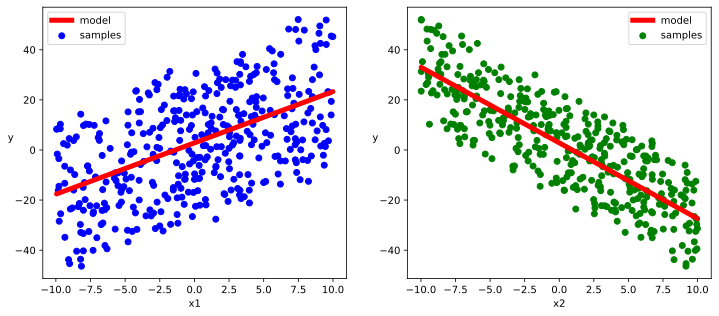

In [25]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

### 2.3、定义模型之高阶API示范
Tensorflow的高阶API主要为tf.keras.models提供的模型的类接口。
使用keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。
此处分别演示使用这三种方式构建模型的过程。

In [27]:
import tensorflow as tf
## Sequential按层顺序构建，model.fit方法训练模型

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers,losses,metrics,optimizers

In [30]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(1,input_shape = (2,)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer = 'adam',loss='mse',metrics=['mae'])
model.fit(X,Y,batch_size=10,epochs=200)
print("w = ",model.layers[0].kernel)
print("b = ",model.layers[0].bias)

Train on 400 samples
Epoch 1/200
400/400 [==============================] - 0s 605us/sample - loss: 4.1555 - mae: 1.6270
Epoch 2/200
400/400 [==============================] - 0s 115us/sample - loss: 4.1504 - mae: 1.6261
Epoch 3/200
400/400 [==============================] - 0s 110us/sample - loss: 4.1556 - mae: 1.6288
Epoch 4/200
400/400 [==============================] - 0s 109us/sample - loss: 4.1490 - mae: 1.6262
Epoch 5/200
400/400 [==============================] - 0s 111us/sample - loss: 4.1539 - mae: 1.6271
Epoch 6/200
400/400 [==============================] - 0s 104us/sample - loss: 4.1485 - mae: 1.6278
Epoch 7/200
400/400 [==============================] - 0s 108us/sample - loss: 4.1466 - mae: 1.6273
Epoch 8/200
400/400 [==============================] - 0s 103us/sample - loss: 4.1470 - mae: 1.6271
Epoch 9/200
400/400 [==============================] - 0s 108us/sample - loss: 4.1476 - mae: 1.6268
Epoch 10/200
400/400 [==============================] - 0s 110us/sample - loss:

Epoch 82/200
400/400 [==============================] - 0s 118us/sample - loss: 4.1498 - mae: 1.6281
Epoch 83/200
400/400 [==============================] - 0s 109us/sample - loss: 4.1450 - mae: 1.6270
Epoch 84/200
400/400 [==============================] - 0s 111us/sample - loss: 4.1454 - mae: 1.6274
Epoch 85/200
400/400 [==============================] - 0s 115us/sample - loss: 4.1434 - mae: 1.6269
Epoch 86/200
400/400 [==============================] - 0s 114us/sample - loss: 4.1493 - mae: 1.6294
Epoch 87/200
400/400 [==============================] - 0s 116us/sample - loss: 4.1506 - mae: 1.6270
Epoch 88/200
400/400 [==============================] - 0s 117us/sample - loss: 4.1465 - mae: 1.6272
Epoch 89/200
400/400 [==============================] - 0s 119us/sample - loss: 4.1435 - mae: 1.6270
Epoch 90/200
400/400 [==============================] - 0s 108us/sample - loss: 4.1458 - mae: 1.6284
Epoch 91/200
400/400 [==============================] - 0s 121us/sample - loss: 4.1495 - ma

400/400 [==============================] - 0s 103us/sample - loss: 4.1460 - mae: 1.6278
Epoch 163/200
400/400 [==============================] - 0s 108us/sample - loss: 4.1481 - mae: 1.6281
Epoch 164/200
400/400 [==============================] - 0s 115us/sample - loss: 4.1433 - mae: 1.6267
Epoch 165/200
400/400 [==============================] - 0s 110us/sample - loss: 4.1454 - mae: 1.6273
Epoch 166/200
400/400 [==============================] - 0s 111us/sample - loss: 4.1452 - mae: 1.6276
Epoch 167/200
400/400 [==============================] - 0s 112us/sample - loss: 4.1463 - mae: 1.6280
Epoch 168/200
400/400 [==============================] - 0s 107us/sample - loss: 4.1454 - mae: 1.6271
Epoch 169/200
400/400 [==============================] - 0s 114us/sample - loss: 4.1459 - mae: 1.6272
Epoch 170/200
400/400 [==============================] - 0s 108us/sample - loss: 4.1440 - mae: 1.6272
Epoch 171/200
400/400 [==============================] - 0s 117us/sample - loss: 4.1441 - mae: 1

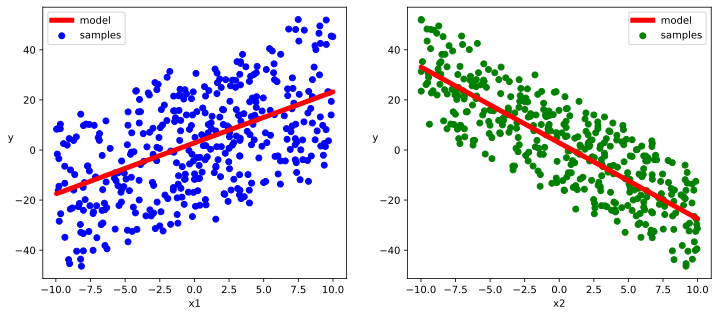

In [34]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

### 二、DNN分类模型
#### 1、准备数据

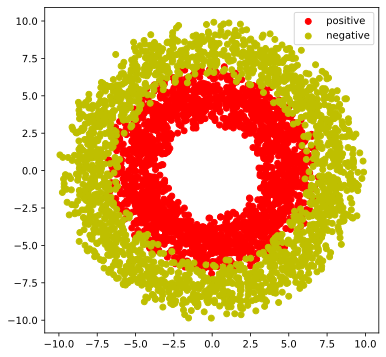

In [45]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "y")
plt.legend(["positive","negative"]);

In [46]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(X,indexs), tf.gather(Y,indexs)
        
# 测试数据管道效果   
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[-2.9001036 -4.678993 ]
 [-1.3079348 -4.5165257]
 [ 4.5003405  1.5961244]
 [-5.9861646 -6.727826 ]
 [ 3.5851939  3.355137 ]
 [ 4.4231486  3.519581 ]
 [-2.2215865 -2.1213877]
 [ 8.237931  -1.1160226]
 [ 1.845511  -6.6356883]
 [-5.6955304  1.3387306]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]], shape=(10, 1), dtype=float32)


#### 2、定义模型
此处范例我们利用tf.Module来组织模型变量，关于tf.Module的较详细介绍参考本书第四章最后一节: Autograph和tf.Module。

In [47]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype = tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]),dtype = tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype = tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]),dtype = tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype = tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]),dtype = tf.float32)

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)])  
    def loss_func(self,y_true,y_pred):  
        #将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred,eps,1.0-eps)
        bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return  tf.reduce_mean(bce)
    
    # 评估指标(准确率)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)]) 
    def metric_func(self,y_true,y_pred):
        y_pred = tf.where(y_pred>0.5,tf.ones_like(y_pred,dtype = tf.float32),
                          tf.zeros_like(y_pred,dtype = tf.float32))
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc
    
model = DNNModel()

In [48]:
#测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)
loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

tf.print("init loss:",loss)
tf.print("init metric:",metric)

init loss: 1.85442007
init metric: 0.6


In [49]:
print(len(model.trainable_variables))

6


#### 3、训练模型

In [50]:
#使用autograph机制转换成静态图加速
@tf.function
def train_step(model,features,labels):
    #正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels,predictions)
        
    grads = tape.gradient(loss,model.trainable_variables)
    for p,dloss_dp in zip(model.trainable_variables,grads):
        p.assign(p - 0.001*dloss_dp)
        
    metric = model.metric_func(labels,predictions)
    return loss,metric

def train_model(model,epochs):
    for epoch in range(epochs):
        for features,labels in data_iter(X,Y,100):
            loss,metric = train_step(model,features,labels)
        if epoch%100==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ", metric)
train_model(model,epochs=600)

================================================================================22:40:08
epoch = 0 loss =  1.42751038 accuracy =  0.5
================================================================================22:40:12
epoch = 100 loss =  0.634139299 accuracy =  0.53
================================================================================22:40:17
epoch = 200 loss =  0.565983176 accuracy =  0.75
================================================================================22:40:21
epoch = 300 loss =  0.461907357 accuracy =  0.87
================================================================================22:40:25
epoch = 400 loss =  0.382380754 accuracy =  0.9
================================================================================22:40:30
epoch = 500 loss =  0.350359052 accuracy =  0.89


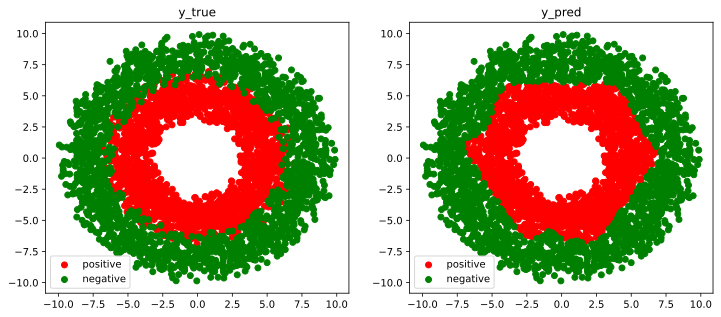

In [51]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

### 高阶模型定义DNN

In [52]:
tf.keras.backend.clear_session()
class DNNModel(models.Model):
    def __init__(self):
        super(DNNModel,self).__init__()
    def build(self,input_shape,num_classes = 1):
        self.dense1 = layers.Dense(4,activation='relu',name="dense1")
        self.dense2 = layers.Dense(8,activation='relu',name="dense2")
        self.dense3 = layers.Dense(num_classes,activation='sigmoid',name="dense3")
        super(DNNModel,self).build(input_shape)
        
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])
    def call(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y
model = DNNModel()
model.build(input_shape=(None,2))
model.summary()

Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               multiple                  12        
_________________________________________________________________
dense2 (Dense)               multiple                  40        
_________________________________________________________________
dense3 (Dense)               multiple                  9         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer = 'adam',loss='mse',metrics=['mae'])
model.fit(X,Y,epochs=100)
print(model.layers[0].weights)

Train on 4000 samples
Epoch 1/100
4000/4000 [==============================] - 0s 112us/sample - loss: 0.2534 - mae: 0.4802
Epoch 2/100
4000/4000 [==============================] - 0s 42us/sample - loss: 0.2333 - mae: 0.4772
Epoch 3/100
4000/4000 [==============================] - 0s 41us/sample - loss: 0.2266 - mae: 0.4696
Epoch 4/100
4000/4000 [==============================] - 0s 39us/sample - loss: 0.2190 - mae: 0.4614
Epoch 5/100
4000/4000 [==============================] - 0s 42us/sample - loss: 0.2107 - mae: 0.4503
Epoch 6/100
4000/4000 [==============================] - 0s 38us/sample - loss: 0.2008 - mae: 0.4372
Epoch 7/100
4000/4000 [==============================] - 0s 40us/sample - loss: 0.1911 - mae: 0.4225
Epoch 8/100
4000/4000 [==============================] - 0s 42us/sample - loss: 0.1813 - mae: 0.4078
Epoch 9/100
4000/4000 [==============================] - 0s 40us/sample - loss: 0.1713 - mae: 0.3918
Epoch 10/100
4000/4000 [==============================] - 0s 40us/sa

4000/4000 [==============================] - 0s 41us/sample - loss: 0.0406 - mae: 0.0943
Epoch 82/100
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0405 - mae: 0.0940
Epoch 83/100
4000/4000 [==============================] - 0s 38us/sample - loss: 0.0399 - mae: 0.0936
Epoch 84/100
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0406 - mae: 0.0940
Epoch 85/100
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0405 - mae: 0.0941
Epoch 86/100
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0403 - mae: 0.0936
Epoch 87/100
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0403 - mae: 0.0936
Epoch 88/100
4000/4000 [==============================] - 0s 42us/sample - loss: 0.0401 - mae: 0.0929
Epoch 89/100
4000/4000 [==============================] - 0s 41us/sample - loss: 0.0403 - mae: 0.0931
Epoch 90/100
4000/4000 [==============================] - 0s 40us/sample - loss: 0.0402 - mae: 

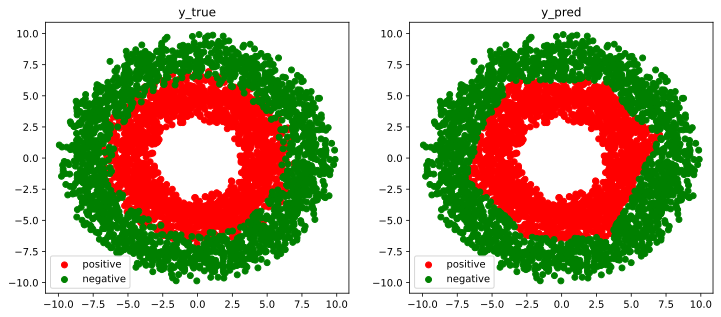

In [54]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

### 中阶API定义模型

In [61]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.dense1 = layers.Dense(4,activation = "relu") 
        self.dense2 = layers.Dense(8,activation = "relu")
        self.dense3 = layers.Dense(1,activation = "sigmoid")

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y
model = DNNModel()
model.loss_func = losses.binary_crossentropy
model.metric_func = metrics.binary_accuracy
model.optimizer = optimizers.Adam(learning_rate=0.001)

In [62]:
(features,labels) =next(ds.as_numpy_iterator())
predictions = model(features)
loss = model.loss_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))
metric = model.metric_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 0.221991152
init metric 0


In [63]:
@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    metric = model.metric_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    
    return loss,metric

@tf.function
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss, metric = tf.constant(0.0),tf.constant(0.0)
        for features, labels in ds:
            loss,metric = train_step(model,features,labels)
        if epoch%10==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ",metric)
train_model(model,epochs = 60)

================================================================================23:00:50
epoch = 10 loss =  -135.127228 accuracy =  0
================================================================================23:00:51
epoch = 20 loss =  -166.366211 accuracy =  0
================================================================================23:00:53
epoch = 30 loss =  -254.290726 accuracy =  0
================================================================================23:00:55
epoch = 40 loss =  -156.318634 accuracy =  0
================================================================================23:00:56
epoch = 50 loss =  -165.035202 accuracy =  0
================================================================================23:00:58
epoch = 60 loss =  -254.319672 accuracy =  0
